In [1]:
import tifffile as tiff
import os
from glob import glob
from tensorflow.keras.utils import img_to_array, load_img
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
train_folder = 'train'
images = []
masks = []

for patient_folder in os.listdir(train_folder):
    img_path = os.path.join(train_folder, patient_folder, 'images')
    mask_path = os.path.join(train_folder, patient_folder, 'masks')

    image_file = glob(os.path.join(img_path, '*.[jp][pn]g'))[0]
    image = load_img(image_file, target_size=(256, 256), color_mode='grayscale')

    image = img_to_array(image) / 255.0
    
    mask_files = glob(os.path.join(mask_path, '*.tiff'))
    mask_combined = np.zeros((256, 256), dtype=np.uint8)

    for mask_file in mask_files:
        mask = tiff.imread(mask_file)
        mask = resize(mask, (256, 256), anti_aliasing=True)
        mask = mask / 255.0
        mask_combined = np.maximum(mask_combined, mask)

    images.append(image)
    masks.append(mask_combined)

In [49]:
x_train, y_train = np.array(images), np.array(masks)

In [26]:
import tensorflow as tf
from keras import layers, models

#foundation model --research more later
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)
    
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_24[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_26[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 128, 128,  │    131,200 │ conv2d_27[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 128, 128,  │    295,040 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_28[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 256, 256,  │     32,832 │ conv2d_29[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 256, 256,  │     73,792 │ concatenate_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_30[0][0] 

 Total params: 1,861,697 (7.10 MB)

 Trainable params: 1,861,697 (7.10 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history = model.fit(x_train, y_train, epochs=25, batch_size=2)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 770ms/step - accuracy: 0.9010 - loss: 1.1921e-07
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 732ms/step - accuracy: 0.8843 - loss: 1.1921e-07
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 701ms/step - accuracy: 0.8918 - loss: 1.1921e-07
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 733ms/step - accuracy: 0.9023 - loss: 1.1921e-07
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - accuracy: 0.8891 - loss: 1.1921e-07
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 705ms/step - accuracy: 0.8694 - loss: 1.1921e-07
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 706ms/step - accuracy: 0.8978 - loss: 1.1921e-07
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 706ms/step - accuracy: 0.8838 - loss: 1.1921e-07
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - accuracy: 0.8881 - loss: 1.1921e-07
Epoch 10/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - accuracy: 0.8901 - loss: 1.1921e-07
Epoch 11/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - accuracy: 0.8704 - loss: 1.1921e-07
Epoch 12

In [66]:
image = load_img('train/DigX_01012009_120804/images/DigX_01012009_120804.jpg', target_size=(256, 256), color_mode='grayscale')
image = img_to_array(image) / 255.0
image = np.expand_dims(x_train[1], axis=0) 

In [67]:
prediction = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


In [68]:
len(x_train[0])

256

In [69]:
predicted_mask = (prediction > 0.5).astype(np.uint8)

In [37]:
predicted_mask = np.squeeze(predicted_mask)


In [70]:
test_image = load_img('/Users/krishna/Desktop/stealth-startup/train/Ajay_Sharma_46_Implant_4.3_10/images/Ajay_Sharma_46_Implant_4.3_10.png', target_size=(256, 256), color_mode='grayscale')
test_image = img_to_array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)

In [71]:
pred = model.predict(test_image)[0]
pred = (pred > 0).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


In [72]:
print(pred.min(), pred.max())  # Check the range of values in the predicted mask


0 0


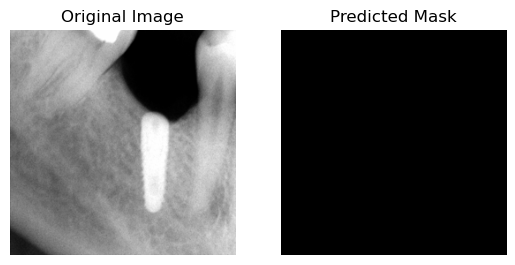

In [73]:
import matplotlib.pyplot as plt

# Assuming you have `original_image` (the input image) and `pred` (the predicted mask)
# Show original image
plt.subplot(1, 2, 1)
plt.imshow(test_image[0].squeeze(), cmap='gray')  # Remove the batch dimension and display
plt.title('Original Image')
plt.axis('off')

# Show predicted mask
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')  # Display the binary mask
plt.title('Predicted Mask')
plt.axis('off')

# Display the images
plt.show()


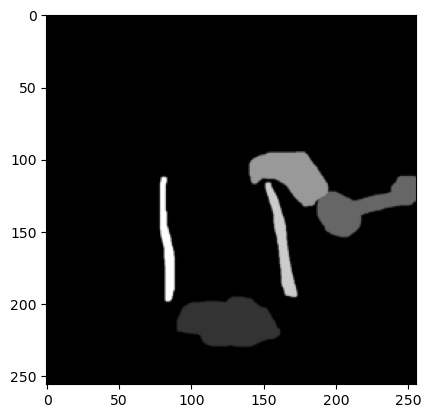

In [75]:
plt.imshow(masks[3], cmap='gray')

In [47]:
# Assuming x_train is a list of file paths
file_name = x_train[10]



[[[0.654902  ]
  [0.6156863 ]
  [0.5764706 ]
  ...
  [0.61960787]
  [0.5058824 ]
  [0.5647059 ]]

 [[0.6       ]
  [0.58431375]
  [0.5803922 ]
  ...
  [0.42352942]
  [0.62352943]
  [0.42352942]]

 [[0.63529414]
  [0.61960787]
  [0.5058824 ]
  ...
  [0.5372549 ]
  [0.5019608 ]
  [0.40784314]]

 ...

 [[0.9882353 ]
  [1.        ]
  [1.        ]
  ...
  [0.7137255 ]
  [0.72156864]
  [0.7058824 ]]

 [[0.9647059 ]
  [1.        ]
  [0.99215686]
  ...
  [0.7607843 ]
  [0.7254902 ]
  [0.6392157 ]]

 [[1.        ]
  [1.        ]
  [1.        ]
  ...
  [0.73333335]
  [0.69803923]
  [0.7490196 ]]]


In [41]:
test_image = x_train[10]
test_output = masks[10]

In [42]:
test_output = (test_output > 0).astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


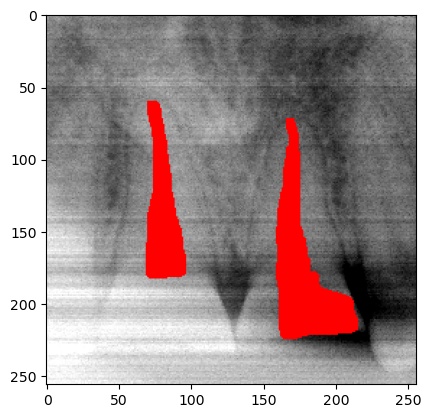

In [43]:

test_output = np.squeeze(test_output) 
test_image = np.squeeze(test_image)   

test_image_rgb = np.stack((test_image,) * 3, axis=-1)

rgb_mask = np.zeros_like(test_image_rgb) 
rgb_mask[:, :, 0] = test_output * 255 

overlay = test_image_rgb.copy()
overlay[test_output == 1] = rgb_mask[test_output == 1]


plt.imshow(overlay)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.0..255.0].


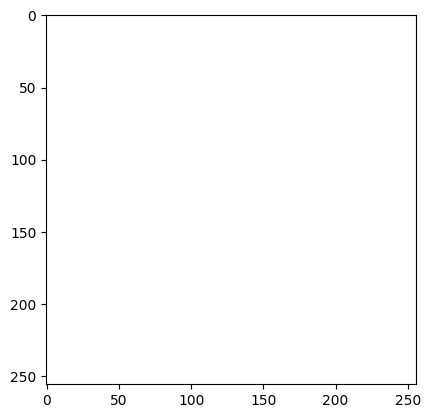

In [262]:
plt.imshow(overlay, cmap='gray')

In [267]:
max(test_output[100])

0.027024565503705418